In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing, svm, linear_model
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
# READING IN THE DATA
df = pd.read_csv('../CapStone/LetsModelBaby.csv')
df.shape

(12878, 96)

In [8]:
pd.options.display.max_columns = 999

In [9]:
# DROPPING UNECESSARY COLUMNS
df.drop('Unnamed: 0', axis=1, inplace=True)

# PROPERLY FORMATTING DATE 
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
## CHECKING THE BASELINE SCORE OF HOW MANY TOTAL OVERS ARE IN THE DATAFRAME
df.loc[df['Over hit?'] == 1].shape

(6243, 95)

#### Baseline score for hitting the over is 48%.

### Now That Binary Outcome Columns Have Been Set, Lets Start Modeling

In [ ]:
### Feature Engineering

In [10]:
# Making new columns for the combined stats of each pitchings and batting stat.
# THESE COLUMNS HAVE ALREADY BEEN SAVED IN THE DATAFRAME, WHICH IS WHY THIS SECTION IS COMMENTED OUT 

# df['Combined_SP_BB%'] = df['Pitcher1_BB%'] + df['Pitcher2_BB%']
# df['Combined_SP_ERA'] = df['Pitcher1_ERA'] + df['Pitcher2_ERA']
# df['Combined_SP_HR/9'] = df['Pitcher1_HR/9'] + df['Pitcher2_HR/9']
# df['Combined_SP_K%'] = df['Pitcher1_K%'] + df['Pitcher2_K%']
# df['Combined_SP_WHIP'] = df['Pitcher1_WHIP'] + df['Pitcher2_WHIP']
# df['Combined_RBIs/Game'] = df['BattingTeam1_RBIs/Game'] + df['BattingTeam2_RBIs/Game']
# df['Combined_Bat_AVG'] = df['BattingTeam1_AVG'] + df['BattingTeam2_AVG']
# df['Combined_Bat_BABIP'] = df['BattingTeam1_BABIP'] + df['BattingTeam2_BABIP']
# df['Combined_Bat_BB%'] = df['BattingTeam1_BB%'] + df['BattingTeam2_BB%']
# df['Combined_Bat_K%'] = df['BattingTeam1_K%'] + df['BattingTeam2_K%']
# df['Combined_Bat_OBP'] = df['BattingTeam1_OBP'] + df['BattingTeam2_OBP']
# df['Combined_bat_slg'] = df['BattingTeam1_SLG'] + df['BattingTeam2_SLG']
# df['Combined_bullpen_k%'] = df['Bullpen1_K%'] + df['Bullpen2_K%']
# df['combined_bp_bb%'] = df['Bullpen1_BB%'] + df['Bullpen2_BB%']
# df['combnied_bp_WHIP'] = df['Bullpen1_WHIP'] + df['Bullpen2_WHIP']
# df['combined_bp_HR/9'] = df['Bullpen1_HR/9'] + df['Bullpen2_HR/9']
# df['combined_bp_ERA'] = df['Bullpen1_ERA'] + df['Bullpen2_ERA']


# Modeling The Over/Under Predictions

In [11]:
# ESTABLISHING THE X AND Y FOR THE Over/Under MODEL. X WILL INCLUDE ALL STATISTICS FROM BOTH BATTING TEAMS 
# AND BOTH PITCHING TEAMS. NOT INCLUDING THE DIFFERENCE BTWN STATS, ONLY THE ADDITION OF STATS. 

X = df.drop(['Date', 'Pitcher1','Pitcher_Team1', 'Pitcher_Team2', 'BattingTeam1', 'BattingTeam2', 'Pitcher2',
        'Pitcher_Team2', 'BattingTeam2', 'Line', 'Opponent_y', 'Over/Under', 'Score', 'Game Line', 'O/U', 'O/U Game Result',
        'Total Runs in Game', 'Win/Loss Game', 'Actual Away Starter', 'Actual Home Starter', 'Bullpen_Team1', 'Bullpen_Team2', 'Over hit?',
            'Winners', 'Home_Team_Win?', 'diff_SP_BB%','diff_SP_ERA','diff_SP_HR/9','diff_SP_K%', 'diff_SP_WHIP','diff_RBIs/Game',
         'diff_Bat_AVG','diff_Bat_BABIP','diff_Bat_BB%','diff_Bat_K%','diff_Bat_OBP','diff_bat_slg','diff_bullpen_k%','diff_bp_bb%','diff_bp_WHIP',
     'diff_bp_HR/9','diff_bp_ERA'], axis=1)


y = df['Over hit?']

In [12]:
len(X.columns)

55

In [17]:
# FUNCTION FOR PRINTING OUT A CONFUSION MATRIX THAT WILL BE USED TO ANALYZE EACH MODEL

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## XGBoost Model

In [45]:
XGBClassifier().get_params

<bound method XGBClassifier.get_params of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)>

In [86]:
model = XGBClassifier()

# setting up xgboost parameters
max_depth = [3,5,7,9]
gamma_range = 10.**np.arange(1, 4)
n_estimators = [20,23,26,30]


# setting up GridSearch
grid = GridSearchCV(estimator=model, cv=5, verbose=1, scoring='accuracy', param_grid=dict(max_depth=max_depth, 
                                                                              n_estimators=n_estimators,
                                                                              gamma=gamma_range))
                                                                          

# fitting model
grid.fit(X, y)

print grid.best_score_
print grid.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.3min finished


0.520500077652
{'n_estimators': 26, 'max_depth': 9, 'gamma': 10.0}


In [37]:
# SETTING UP XGB CLASSIFIER UTILIZING BEST PARAMETERS FROM GRID SEARCH
model = XGBClassifier(n_estimators=26, max_depth=10, gamma=100.0)

# FITTING MODEL
model.fit(X_train, y_train)

# PREDICTING TEST SET
y_preds = model.predict(X_test)

y_preds2 = model.predict_proba(X_test)


In [39]:
accuracy_score(y_test, y_preds)

0.51529411764705879

Confusion matrix, without normalization
[[2190    0]
 [2060    0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


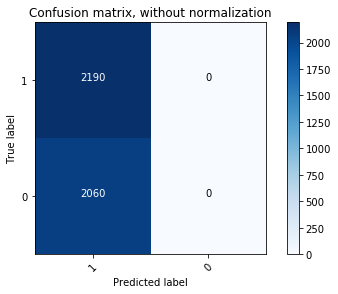

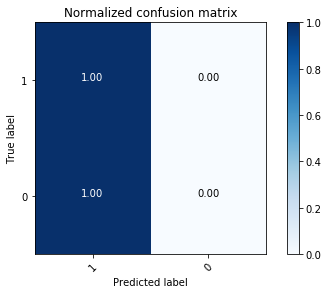

In [43]:
# PRINTING OUT CONFUSION MATRIX OF ABOVE MODEL

class_names = y.unique()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Random Forest Classifier

In [69]:
clf = RandomForestClassifier()

# setting grid-searching parameters:
n_estimators = [1,2,4,8,10]
criterion = ['gini', 'entropy']
max_features = ['auto', 'log2', 3, 8]
max_depth = [1,2,4, 8]

grid = GridSearchCV(estimator=clf, cv=5, verbose=1, scoring='accuracy', param_grid=dict(n_estimators=n_estimators,
                                                                             criterion=criterion,
                                                                             max_features=max_features,
                                                                             max_depth=max_depth))

grid.fit(X, y)

print grid.best_score_
print grid.best_params_

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:  1.5min finished


0.520500077652
{'max_features': 'log2', 'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 4}


In [45]:
# SETTING UP RANDOM FOREST MODEL UTILIZING OPTIMAL FEATURES FROM ABOVE GRID SEARCH
clf = RandomForestClassifier(max_features='log2', n_estimators=10, criterion='entropy', max_depth=4)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [46]:
# PRINTING ACCURACY SCORE OF ABOVE MODEL
accuracy_score(y_test, y_pred)

0.51129411764705879

Confusion matrix, without normalization
[[1807  383]
 [1694  366]]
Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.82  0.18]]


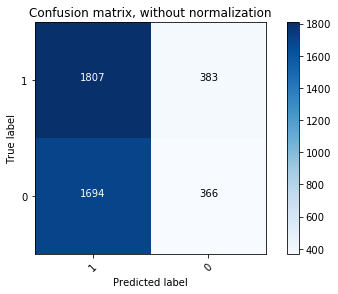

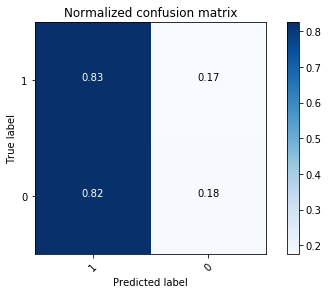

In [48]:
# PRINTING OUT CONFUSION MATRIX OF ABOVE MODEL

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [64]:
# SETTING UP RANDOM FOREST MODEL UTILIZING OPTIMAL FEATURES FROM ABOVE GRID SEARCH
clf = RandomForestClassifier(max_features='auto', n_estimators=5, criterion='entropy', max_depth=3)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.51411764705882357

Confusion matrix, without normalization
[[1924  266]
 [1799  261]]
Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.87  0.13]]


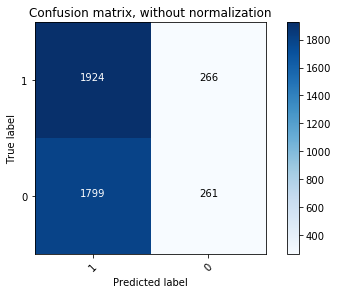

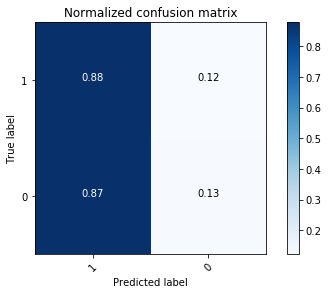

In [65]:
# PRINTING OUT CONFUSION MATRIX OF ABOVE MODEL

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

In [69]:
# NORMALIZING FEATURES FOR LOGISTIC REGRESSION MODEL
X_norm = preprocessing.normalize(X)

Xtrain_norm = preprocessing.normalize(X_train)

In [70]:
# running simple Logistic Regression Before Grid Searching to see accuracy of model performs
model = LogisticRegression()

model.fit(Xtrain_norm, y_train)

y_preds = model.predict(X_test)

In [71]:
accuracy_score(y_test, y_preds)

0.49176470588235294

In [79]:
## GRIDSEARCHING LOGISTIC REGRESSION
model = LogisticRegression()

# establishing parameters to gridsearch
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weights = ['balanced', None]


grid = GridSearchCV(estimator=model, cv=5, verbose=1, scoring='accuracy', param_grid=dict(penalty=penalty,
                                                                              C=C,
                                                                              class_weight = class_weights))


grid.fit(X,y)

print grid.best_score_
print grid.best_params_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed: 22.7min finished


0.518947041466
{'penalty': 'l2', 'C': 1, 'class_weight': None}


In [72]:
model = LogisticRegression(penalty = 'l2', C=1.0, class_weight=None)

model.fit(Xtrain_norm, y_train)

preds = model.predict(X_test)

In [73]:
accuracy_score(y_test, y_preds)

0.49176470588235294

Confusion matrix, without normalization
[[ 111 2079]
 [  81 1979]]
Normalized confusion matrix
[[ 0.05  0.95]
 [ 0.04  0.96]]


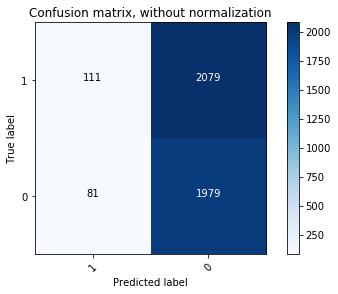

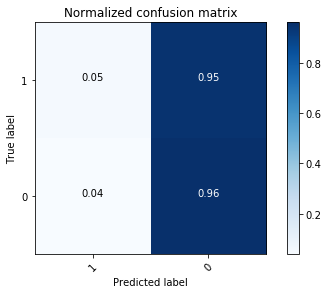

In [74]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()